No GPU available, using the CPU instead.


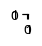

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
# pd.set_option("display.max_columns",999)
# pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

import src.models
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, HLAS, AA_KEYS
from src.data_processing import get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

RESDIR='../output/220906_analysis/'
BOOTDIR='../output/bootstrapping/'

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    

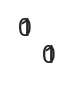

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar = pd.read_csv('../data/partitioned_traindata/cedar_10fold.csv')
cedar['trainset']='cedar'

cedar_viral_old = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
cedar_viral_old['trainset']='cedar_virus_old'

cedar_viral_more = pd.read_csv('../data/partitioned_traindata/new_cedar_viral_5fold.csv')
cedar_viral_more['trainset']='cedar_virus_new'
# USE PRIME FOR BASELINE VERIFICATION, PRIME_FOLD FOR ACTUAL TRAINING
prime_fold = pd.read_csv('../data/partitioned_traindata/prime_5fold.csv')
prime_fold['trainset']='prime'

prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)
prime['len'] = prime['Mutant'].apply(len)
prime['HLA'] = prime['Allele'].apply(lambda x: 'HLA-'+x)

viral_only = pd.read_csv('../data/partitioned_traindata/viral_only_5fold.csv')
viral_only['trainset']='virus'

cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_hp_uni['trainset']='cedar_hp_rank_uni'

cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
cedar_hp_low['trainset']='cedar_hp_rank_low'

cedar_hp_fold = pd.read_csv('../data/partitioned_traindata/cedar_hp_fold_balanced.csv')
cedar_hp_fold['trainset'] = 'cedar_balanced'

cedar_mut_fold = pd.read_csv('../data/partitioned_traindata/cedar_subst_mut_10fold.csv')

# newdump load and parse

In [5]:
from src.data_processing import get_aa_properties, AA_KEYS
from src.mutation_tools import get_anchor, get_anchor_mutation, get_binder_type, get_blsm_mutation_score, get_mutation_pos, get_mutation_score, get_mutation_type

In [14]:
cedar_short = pd.read_excel('../data/raw/neo_OCT2022_full_res_assays.xlsx')
cedar_epi = pd.read_excel('../data/raw/neo_OCT2022_full_res_epitopes.xlsx')
old_epi = pd.read_excel('../data/raw/neo_JUN2022_full_res.xlsx', sheet_name='epitopes')

In [15]:
len(cedar_epi), len(old_epi)

(3984, 3928)

In [16]:
from src.data_processing import AA_KEYS, BL62_VALUES, BL62, BL62FREQ_VALUES

# Reading epi
cedar_epi = pd.read_excel('../data/raw/neo_JUN2022_full_res.xlsx', sheet_name='epitopes')
print('start', len(cedar_epi))
# Adding the wild-type peptide & Merging the related info with the cedar_epi dump
rel_cols = ['Epitope_Description', 'MHC_Allele Name', 'Related Object_Description', 'Related Object_Starting Position', 'Related Object_Ending Position']#
related = cedar_short.sort_values('Epitope_Description').drop_duplicates(['Epitope_Description', 'MHC_Allele Name'])[rel_cols]
print(1, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)
cedar_epi = cedar_epi.merge(related, left_on=['Epitope_Description', 'MHC_Allele Name'], right_on = ['Epitope_Description', 'MHC_Allele Name'])
print(2, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)
print('After merge', len(cedar_epi))

# Get the length of the peptide & Querying only length 8 to 12 (Only lens for which we have our motifs)
cedar_epi['len'] = cedar_epi['Epitope_Description'].apply(len)
cedar_epi = cedar_epi.query('len>=8 and len <=12')
print(3, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)
print('After len check', len(cedar_epi))

# Filter out XYZ- etc characters in peptide
cedar_epi.drop(index=cedar_epi.loc[cedar_epi['Epitope_Description'].apply(lambda x: any([z for z in x if z not in AA_KEYS]))].index, inplace=True)
print(4, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)
print('After XYZ', len(cedar_epi))

# Keeping on HLA alleles where there is at least one positive Peptide (i.e. discard Alleles with only negatives)
hlas_to_keep = [x for x in cedar_epi.query('label=="Positive"')['MHC_Allele Name'].unique() if 'D' not in x]
print('N HLAs to keep', len(hlas_to_keep))
cedar_epi = cedar_epi.query('`MHC_Allele Name` in @hlas_to_keep')
print(5, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)

print('After HLA positive', len(cedar_epi))

# Keeping only MHC Class I
cedar_epi = cedar_epi.query('not `MHC_Allele Name`.str.contains("D")', engine='python')
print(6, len(cedar_epi.query('Epitope_Description=="CLAVEEVSL"'))==0)
print('After class II', len(cedar_epi))

# Adding some new columns
cedar_epi['total_count'] = cedar_epi['responses'].apply(lambda x: len(x.split(',')))
cedar_epi['percentage_pos'] = (cedar_epi['responses'].apply(lambda x: sum([1 for x in x.split(',') if 'Positive' in x]))/cedar_epi['total_count'])
cedar_epi['agg_label']=cedar_epi['label'].apply(lambda x: 1 if x=='Positive' else 0)

# Renaming columns 
cedar_epi.rename(columns = {'Epitope_Description': 'Peptide',
                            'MHC_Allele Name': 'HLA',
                             'Related Object_Description': 'wild_type'}, inplace=True)
# replacing HLA to simple form
cedar_epi['HLA_full'] = cedar_epi['HLA']
cedar_epi['HLA'] = cedar_epi['HLA_full'].apply(lambda x: x.replace('*','').replace(':',''))

start 3928
1 False
2 False
After merge 3858
3 False
After len check 3582
4 False
After XYZ 3582
N HLAs to keep 60
5 False
After HLA positive 3389
6 False
After class II 3389


In [6]:
def get_true_wt(wt):
    return wt==wt.upper() and all([x in AA_KEYS for x in wt])
new_epi

,Epitope_Description,MHC_Allele Name,PMIDs,responses,label
0,AAAAAAQQIQV,HLA-B*07:02,27198675,Negative,Negative
1,AAAAQQIQV,HLA-A*02:01,27198675,Negative,Negative
2,AAAAQQIQV,HLA-B*07:02,27198675,Negative,Negative
3,AAFIWIISM,HLA-B*35:01,27198675,Negative,Negative
4,AAHFTVLLY,HLA-A*11:01,31511069,Negative,Negative
...,...,...,...,...,...
3979,YYPGKKEPF,HLA-A*24:02,"34270940,34270940","Negative,Negative",Negative
3980,YYPPSQIAQL,HLA-A*24:02,26048577,Positive_all,Positive
3981,YYSKNLNSF,HLA-A*24:02,28423700,Positive_all,Positive
3982,YYSKNLNSFF,HLA-A*24:02,"28423700,28423700","Positive_all,Positive_all",Positive
